<a href="https://colab.research.google.com/github/grantzhou123/mnist/blob/main/segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# データの準備
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # MNISTデータセットの平均と標準偏差で正規化
])

# MNISTデータセットの読み込み
train_dataset = datasets.MNIST(root='./data', train=True,
                               transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False,
                              transform=transform, download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 152659932.16it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 113849336.30it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 46809330.86it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21261750.86it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
# DataLoaderの設定
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

In [4]:
# ネットワークの定義
class SegmentationCNN(nn.Module):
    def __init__(self):
        super(SegmentationCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        self.conv4 = nn.Conv2d(64, 2, kernel_size=1)  # 出力チャネルを2に設定（背景と前景）

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.conv4(x)
        return x

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SegmentationCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [6]:
# 訓練ループ
num_epochs = 10
for epoch in range(num_epochs):
    loss_epoch = 0.0
    for data in train_loader:
        img, _ = data
        img = img.to(device)
        # 二値化ではなく、正規化されたデータをそのまま使用
        target = (img[:, 0, :, :] > 0.5).long().to(device)  # ラベルデータの生成

        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        loss_epoch += loss.item()
    print(f'Epoch: {epoch+1}/{num_epochs}, Loss: {loss_epoch:.4f}')

Epoch: 1/10, Loss: 15.7339
Epoch: 2/10, Loss: 3.2247
Epoch: 3/10, Loss: 2.5824
Epoch: 4/10, Loss: 2.2826
Epoch: 5/10, Loss: 2.0779
Epoch: 6/10, Loss: 1.8681
Epoch: 7/10, Loss: 1.7918
Epoch: 8/10, Loss: 1.6054
Epoch: 9/10, Loss: 1.5467
Epoch: 10/10, Loss: 1.5513


In [7]:
# モデルの評価
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, _ = data
        images = images.to(device)
        target = (images[:, 0, :, :] > 0.5).long().to(device)  # 二値化を用いてラベルを生成
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0) * target.size(1) * target.size(2)  # 画像の総ピクセル数
        correct += (predicted == target).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total} %')

Accuracy of the network on the 10000 test images: 99.92619897959183 %


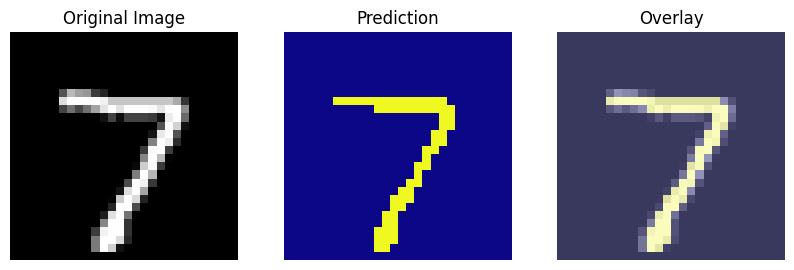

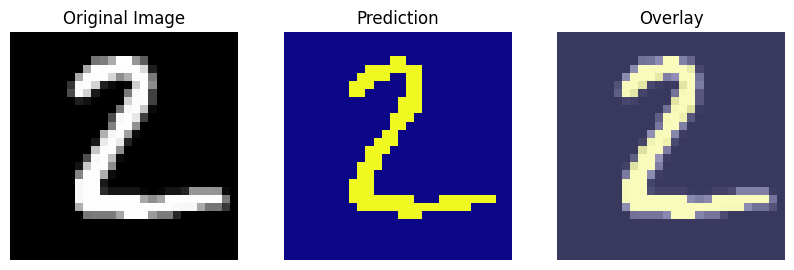

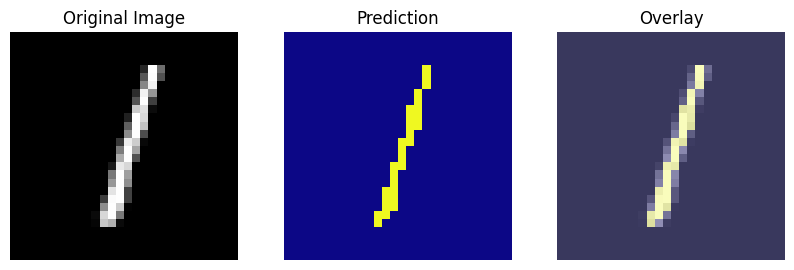

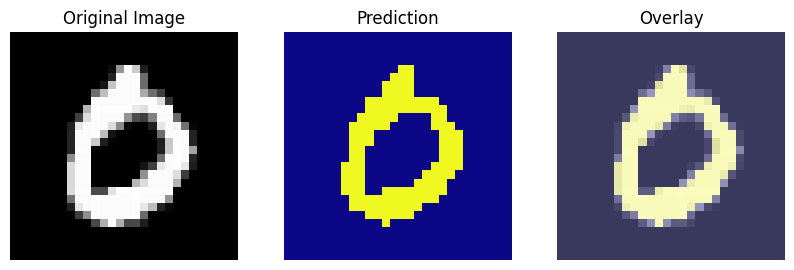

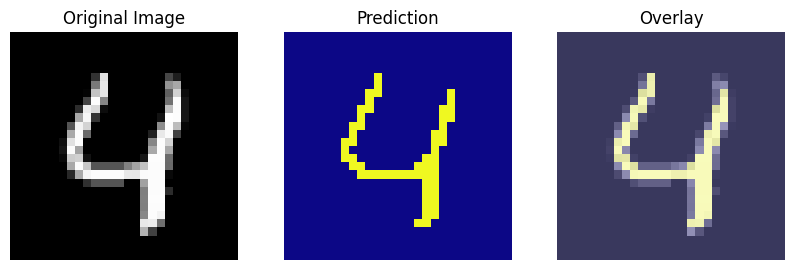

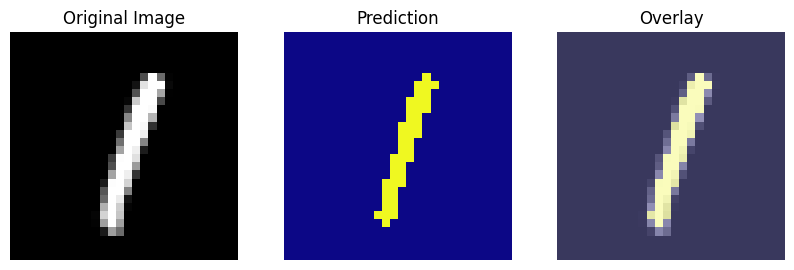

In [8]:
# テストデータからランダムに画像を選択して予測と可視化
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

for i in range(6):  # 6枚の画像に対して処理を行う
    with torch.no_grad():
        output = model(example_data[i].unsqueeze(0).to(device))

    pred = output.data.max(1, keepdim=True)[1]  # 予測結果を取得

    img_np = example_data[i][0].cpu().numpy()
    pred_np = pred.cpu().numpy().squeeze()

    fig, ax = plt.subplots(1, 3, figsize=(10, 3))
    ax[0].imshow(img_np, cmap='gray')
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    ax[1].imshow(pred_np, cmap='plasma')
    ax[1].set_title('Prediction')
    ax[1].axis('off')

    ax[2].imshow(img_np, cmap='gray', alpha=0.7)
    ax[2].imshow(pred_np, cmap='plasma', alpha=0.3)
    ax[2].set_title('Overlay')
    ax[2].axis('off')

    plt.show()